In [5]:
from scipy.fft import fft
import torch 
import pickle
import matplotlib.pyplot as plt

# Load the dataset

with open ('interaction_matrices.pkl', 'rb') as int_matrices:
    interaction_matrices = pickle.load(int_matrices)

with open ('spectra_dataset.pkl', 'rb') as spec_dataset:
    spec_dataset = pickle.load(spec_dataset)


# converting the dataset to numpy arrays

interaction_matrices = interaction_matrices.numpy()
spec_dataset = spec_dataset.numpy()

In [6]:
print(spec_dataset.shape)
print(interaction_matrices.shape)

# data is in good shape 
# NMF Y ~ WH
# Y is the dataset
# W IS THE BASIS MATRIX AND H IS THE COEFFICIENT MATRIX



(10000, 20000)
(10000, 6, 6)


In [7]:
from sklearn.decomposition import NMF
import numpy as np
import seaborn as sns

selected_spec = spec_dataset[:10000,:]
print(selected_spec.shape)

model = NMF(n_components=75, init='nndsvd', random_state=40, max_iter=200, beta_loss='frobenius')
W = model.fit_transform(selected_spec)
H = model.components_

approximation = np.dot(W,H)

reconstruction_error = np.linalg.norm(selected_spec - approximation, 'fro')
print("Forbenius norm error:", reconstruction_error)

(10000, 20000)


/Users/sanazkazeminia/anaconda3/envs/Mass_Spec/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Forbenius norm error: 0.0010816733


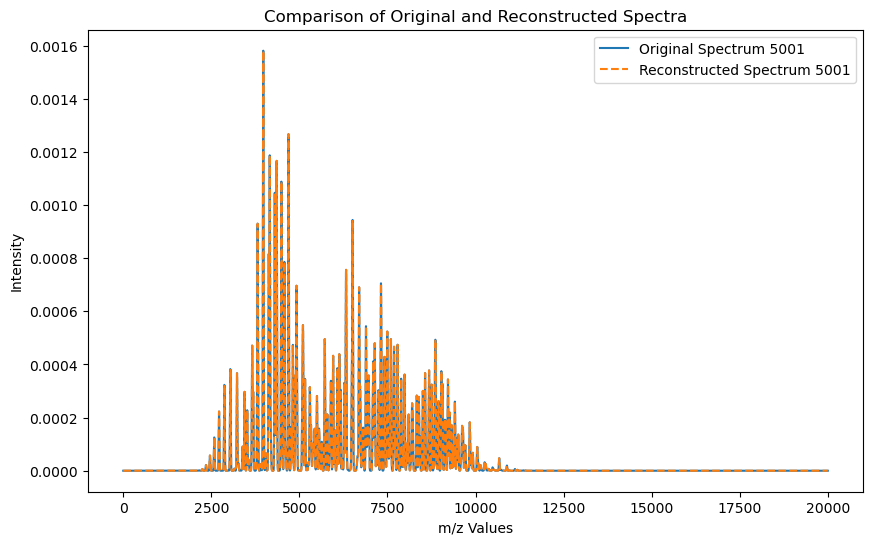

Text(0, 0.5, 'Intensity')

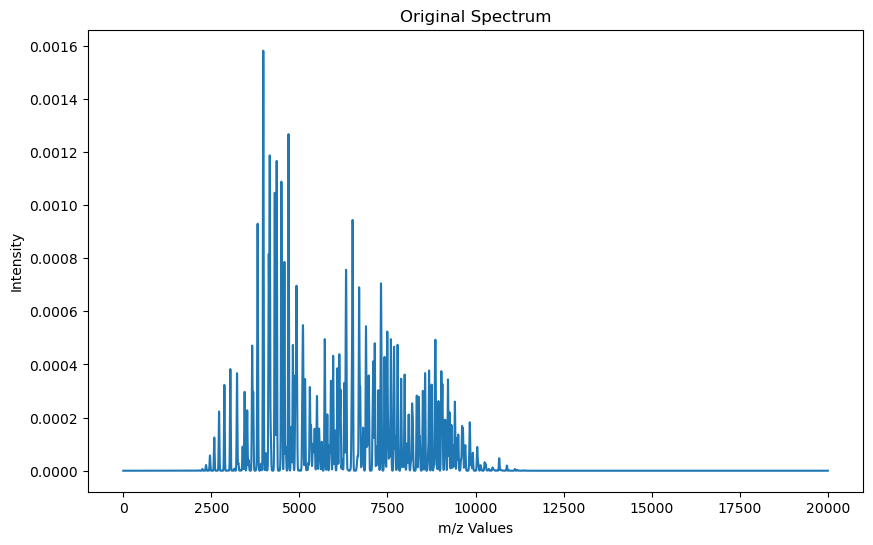

In [8]:
# Select a few spectra to plot
spectra_indices = [5000]  # For example, the first, 11th, and 21st spectra

plt.figure(figsize=(10, 6))

for idx in spectra_indices:
    plt.plot(selected_spec[idx, :], label=f'Original Spectrum {idx+1}')
    plt.plot(approximation[idx, :], label=f'Reconstructed Spectrum {idx+1}', linestyle='--')

plt.legend()
plt.title('Comparison of Original and Reconstructed Spectra')
plt.xlabel('m/z Values')
plt.ylabel('Intensity')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(spec_dataset[5000,:])
plt.title('Original Spectrum')  
plt.xlabel('m/z Values')
plt.ylabel('Intensity')


In [54]:
# convert the numpy arrays to torch tensors
# W is the components matrix and has dimesnions 10,000 x 75 with 75 representing the spectra features


In [9]:
from sklearn.model_selection import train_test_split

spectra = torch.tensor(W)
torch.save(spectra, 'spectraCNN.pt')
interaction_matrices = torch.tensor(interaction_matrices)
torch.save(interaction_matrices, 'interaction_matricesCNN.pt')

spectra_train_val, spectra_test, matrix_train_val, matrix_test = train_test_split(spectra, interaction_matrices, test_size=0.2, random_state=42)
spectra_train, spectra_val, matrix_train, matrix_val = train_test_split(spectra_train_val, matrix_train_val, test_size=0.1, random_state=42)

In [10]:
print("Training Set:", spectra_train.shape, matrix_train.shape)
print("Validation Set:", spectra_val.shape, matrix_val.shape)
print("Test Set:", spectra_test.shape, matrix_test.shape)




Training Set: torch.Size([7200, 75]) torch.Size([7200, 6, 6])
Validation Set: torch.Size([800, 75]) torch.Size([800, 6, 6])
Test Set: torch.Size([2000, 75]) torch.Size([2000, 6, 6])


In [11]:
from torch.utils.data import Dataset

class SpectraMatrixDataset(Dataset):
    """Dataset wrapping spectra and matrix data."""
    def __init__(self, spectra, matrices):
        self.spectra = spectra
        self.matrices = matrices

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        return self.spectra[idx], self.matrices[idx]


In [12]:
from torch.utils.data import DataLoader

train_dataset = SpectraMatrixDataset(spectra_train, matrix_train)
val_dataset = SpectraMatrixDataset(spectra_val, matrix_val)
test_dataset = SpectraMatrixDataset(spectra_test, matrix_test)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [13]:
import torch
import torch.nn as nn

class SpectraMatrixNet(nn.Module):
    def __init__(self):
        super(SpectraMatrixNet, self).__init__()
        self.spectra_processor = nn.Sequential(
            nn.Linear(75, 128),  # Assume input features are 75-dimensional
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU()
        )
        
        self.matrix_processor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Assuming input matrix is 6x6 with 1 channel
            nn.ReLU(),
            nn.MaxPool2d(2),  # Halves the dimension: 6x6 to 3x3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 3 * 3, 256),  # Adjust this based on the actual output size after pooling
            nn.ReLU()
        )
        
        self.combiner = nn.Sequential(
            nn.Linear(256 + 256, 512),
            nn.ReLU(),
            nn.Linear(512, 36),  # Change here to match the 6x6 matrix output
        )

    def forward(self, spectra, matrix):
        spectra_features = self.spectra_processor(spectra)
        matrix = matrix.unsqueeze(1)  # Adding a channel dimension for Conv2d
        matrix_features = self.matrix_processor(matrix)
        combined = torch.cat((spectra_features, matrix_features), dim=1)
        output = self.combiner(combined)
        return output.view(-1, 6, 6)  # Reshape to 6x6 matrix

# Example instantiation and forward pass check
model = SpectraMatrixNet()
# Assuming random input for demonstration
spectra_sample = torch.randn(10, 75)  # 10 samples, each with 75 features
matrix_sample = torch.randn(10, 6, 6)  # 10 samples, each a 6x6 matrix
output = model(spectra_sample, matrix_sample)
print(output.size())  # Expecting [10, 6, 6]


torch.Size([10, 6, 6])


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Ensure train_dataset is already defined.

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

for epoch in range(5):
    model.train()  # Set the model to training mode
    epoch_loss = 0

    for spectra_train, matrix_train in train_loader:
        optimizer.zero_grad()
        output = model(spectra_train, matrix_train)
        loss = criterion(output, matrix_train)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.08553702384233475
Epoch 2, Loss: 0.08457562327384949
Epoch 3, Loss: 0.088265061378479
Epoch 4, Loss: 0.08102811127901077
Epoch 5, Loss: 0.09033822268247604


In [21]:
model.eval()  # Set the model to evaluation mode

# Assuming 'val_loader' is your DataLoader for validation data
validation_loss = 0.0
criterion = nn.MSELoss()  # or any other appropriate loss function

with torch.no_grad():  # No need to track gradients during validation
    for spectra_val, matrix_val in val_loader:
        predicted_matrices = model(spectra_val, matrix_val)
        loss = criterion(predicted_matrices, matrix_val)
        validation_loss += loss.item()

# Calculate average loss over all validation batches
average_validation_loss = validation_loss / len(val_loader)
print(f'Average Validation Loss: {average_validation_loss}')


Average Validation Loss: 0.12152481436729431
